# Control of a solar home with Stochastic Dynamic Programming (SDP)

using the [stodynprog](https://github.com/pierre-haessig/stodynprog) package

Pierre Haessig, July 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy.stats as stats

In [3]:
from stodynprog import SysDescription, DPSolver

Import solarhome utility module

In [4]:
from pathlib import Path
p_utils = Path('../../utils')
assert(p_utils.exists())

import sys
sys.path.append(str(p_utils))

import benchutils
from benchutils import load_data, load_results

### Load testcase data

Test data

In [5]:
params, data = load_data()
data.head(3)

,P_load_sp,P_sun_1k,c_grid
0.0,0.520,0.0,0.1
0.5,0.528,0.0,0.1
1.0,0.496,0.0,0.1


Training data

In [6]:
params, data_train = load_data(subset='train')

In [7]:
n = len(data)
ndays = n//48 # days
ndays

30

Solar home parameters:

In [8]:
E_rated = params['E_rated'] # kWh
P_pvp = params['P_pvp'] # kW
print('E_rated: {:.1f} kWh'.format(E_rated))
print('P_pvp: {:.1f} kW'.format(P_pvp))

E_rated: 8.0 kWh
P_pvp: 4.0 kW


Battery power (unspecified in the base problem)

In [9]:
P_rated = 3 # kW

Extract time series of test data

In [10]:
P_load = data.P_load_sp
P_sun = data.P_sun_1k*P_pvp;

t = data.index
dt = t[1] - t[0]
td = t/24 #days

In [11]:
print('Average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('Average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Average sun energy: 15.60 kWh/d
Average load      : 17.02 kWh/d
ratio sun/load: 91.70%


Extract time series of training data

In [12]:
P_load_train = data_train.P_load_sp
P_sun_train = data_train.P_sun_1k*P_pvp;

In [13]:
print('Average sun energy: {:.2f} kWh/d'.format(P_sun_train.mean()*24))
print('Average load      : {:.2f} kWh/d'.format(P_load_train.mean()*24))
print('ratio sun/load: {:.2%}'.format(P_sun_train.mean()/P_load_train.mean()))

Average sun energy: 14.70 kWh/d
Average load      : 18.19 kWh/d
ratio sun/load: 80.82%


Demo plot of input data

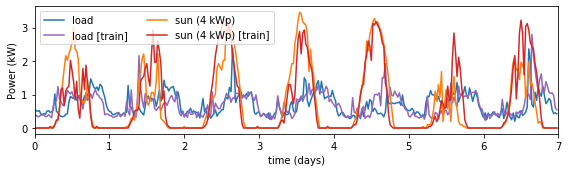

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8,2.5))
z = slice(0, 7*48)
ax.plot(td[z], P_load.iloc[z], label='load', color='tab:blue')
ax.plot(td[z], P_load_train.iloc[z], label='load [train]', color='tab:purple')
ax.plot(td[z], P_sun.iloc[z], label='sun ({} kWp)'.format(P_pvp), color='tab:orange')
ax.plot(td[z], P_sun_train.iloc[z], label='sun ({} kWp) [train]'.format(P_pvp), color='tab:red')

ax.legend(ncol=2)

ax.set(
    xlim = (0,7),
    xlabel = 'time (days)',
    ylabel = 'Power (kW)'   
)
fig.tight_layout()

## Model of uncertainty: iid

### Building net load:

In [24]:
P_nl_train = P_load_train - P_sun_train

Fold the data day by day:

In [25]:
P_nl_train_daily = P_nl_train.values.reshape((-1,48))
P_nl_train_daily.shape

(30, 48)

resulting array can be indexed as `P_nl_train_daily[d,h]` with `d` in [0,29] and `h` in [0,47].

Vectorized slicing is also possible:

In [26]:
P_nl_train_daily[0,np.array([1,2,2])]

array([0.378, 0.342, 0.342])

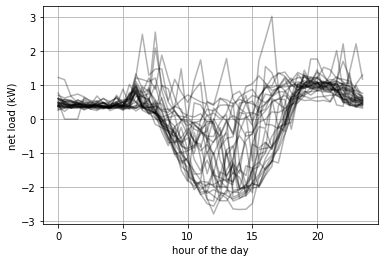

In [28]:
hod = np.arange(48)/2
plt.plot(hod, P_nl_train_daily.T, 'k-', alpha=0.3);
plt.xlabel('hour of the day')
plt.ylabel('net load (kW)')
plt.grid();

Sorted data at each hour of the day

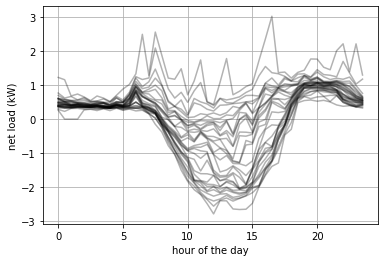

In [32]:
P_nl_sort = np.sort(P_nl_train_daily, axis=0)

plt.plot(hod, P_nl_sort.T, 'k-', alpha=0.3);
plt.xlabel('hour of the day')
plt.ylabel('net load (kW)')
plt.grid();

### Distribution at each hour of the day

In [29]:
#sampling scheme: P_nl_train_daily[d,h]

In [30]:
np.arange(10)[0:1]

array([0])

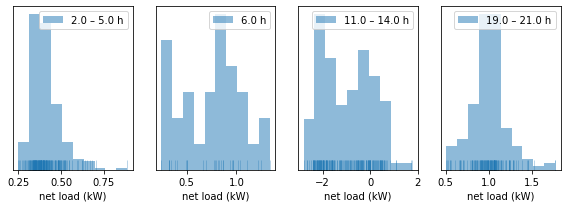

In [31]:
def plot_distrib(ax, hi1, hi2, color):
    a = P_nl_train_daily[:,hi1:hi2].flatten()
    ax.plot(a, np.zeros_like(a), '|', ms=20,
            alpha=0.3, color=color)
    h1 = hod[hi1]
    h2 = hod[hi2-1]
    label = f'{h1} – {h2} h' if h2>h1 else f'{h1} h'
    ax.hist(a, density=True, label=label,
            alpha=0.5, color=color)
    ax.legend()
    ax.set(
        xlabel='net load (kW)'
    )
    ax.set_yticks([])

fig, ax = plt.subplots(1,4, figsize=(8,3))

plot_distrib(ax[0], 4, 11, 'C0')
plot_distrib(ax[1], 12, 13, 'C0')
plot_distrib(ax[2], 22, 29, 'C0')
plot_distrib(ax[3], 38, 43, 'C0')
fig.tight_layout()

### Simple gaussian model at each hour of  the day

In [34]:
P_nl_m = P_nl_train_daily.mean(axis=0)
P_nl_s = P_nl_train_daily.std(axis=0)

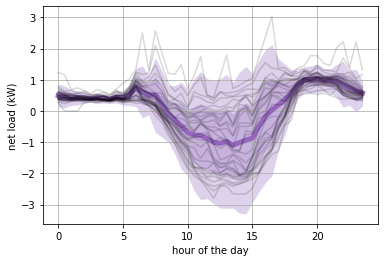

In [49]:
plt.fill_between(hod, P_nl_m-2*P_nl_s, P_nl_m+2*P_nl_s,
                 color='tab:purple', alpha=0.3, lw=0
                )
plt.fill_between(hod, P_nl_m-1*P_nl_s, P_nl_m+1*P_nl_s,
                 color='tab:purple', alpha=0.3, lw=0
                )
plt.plot(hod, P_nl_m, '-', color='tab:purple',
         alpha=1, lw=5);

plt.plot(hod, P_nl_sort.T, 'k-', alpha=0.15);


plt.xlabel('hour of the day')
plt.ylabel('net load (kW)')
plt.grid();

## SDP describtion

### Dynamics


Variables of the problem:

* 3 state variables: 
  * stored energy $E_{sto}$
  * net load $P_{nl}$
  * the hour of the day $hod$ 
* 1 control:
  * either $P_{sto}$ because $P_{gc}$  (grid - curtailment power) is deduced from energy conservation: $P_{gc} = P_{nl} + P_{sto}$
  * or $P_{gc}$ (grid - curtailment power) because $P_{sto}$ is deduced from energy conservation: $P_{sto} = P_{gc} - P_{nl}$
* 1 perturbation: $di$ ('day index') which influences $P_{nl}$ future value

#### Uniform integer uncertainty

In [131]:
30/5

6.0

In [217]:
def dyn_randint(E, P_nl, h, P_sto, di):
    '''state transition the solar home, with iid net load model
    based on a uniform random integer in [0,29] (day indices in the training set)
    
    returns (E(k+1), P_nl(k+1), h(k+1))
    '''
    # 1) Stored energy evolution:
    E_next = E + P_sto*dt
    # 2) next hour of the day
    # add a bit of randomness with time evolution
    # +0 w.p. 1/5, +1 w.p. 3/5, +2 w.p. 1/5
    #deltat = np.where((di%5)==0, 0, dt)
    #deltat = np.where((di%5)==1, 2*dt, deltat)
    deltat = dt
    int_h_next = np.round(2*(h + deltat)).astype(int) % 48
    h_next = int_h_next/2
    # 3) next P_nl value: sample training day `di` at hour `h_next`
    P_nl_next = P_nl_train_daily[di,int_h_next]
    
    return (E_next, P_nl_next, h_next)

# Test:
dyn_randint(5, 2, 23.5,
           1, 10)

(5.5, 0.77, 0.0)

Innov law: uniform integers (day indices in the training set)

In [133]:
di_law = stats.randint(low=0, high=30) # high is not included

#### Gaussian innovation

perturbation w is a normal law which gets rescaled based on $h$ value

$P_{nl}(k+1) = \mu(h(k+1)) + \sigma(h(k+1)).w(k)$

In [58]:
def dyn_norm(E, P_nl, h, P_sto, w):
    '''state transition the solar home, with iid normal perturation
    rescaled to make P_nl(k+1)
    
    returns (E(k+1), P_nl(k+1), h(k+1))
    '''
    # 1) Stored energy evolution:
    E_next = E + P_sto*dt
    # 2) next hour of the day
    int_h_next = np.round(2*(h + dt)).astype(int) % 48
    h_next = int_h_next/2
    # 3) next P_nl value:
    P_nl_next = P_nl_m[int_h_next] + w*P_nl_s[int_h_next]
    
    return (E_next, P_nl_next, h_next)

# Test:
dyn_norm(5, 2, 23.5,
           1, 1.96)

(5.5, 0.8461062969092663, 0.0)

In [60]:
w_law = stats.norm()

### Set of admissible controls

In [59]:
def admissible_controls(E, P_nl, h):
    '''set of admissible control U(x_k) of an Energy storage
    control is P_sto
    ''' 
    # 1) Constraints on P_sto:
    P_neg = np.max((           -E /dt, -P_rated))
    P_pos = np.min(( (E_rated - E)/dt, +P_rated))
    U1 = (P_neg, P_pos)
    return (U1, )

# Test:
admissible_controls(1, 0, 0)

((-2.0, 3.0),)

In [61]:
admissible_controls(7, 0, 0)

((-3.0, 2.0),)

### Cost function

cost is the grid cost

In [259]:
3*0.1 + 3**2*1e-3

0.30900000000000005

In [265]:
def cost(E, P_nl, h, P_sto, di):
    '''grid cost function of x,u,w
    '''
    # Grid power
    P_gc = P_nl + P_sto
    P_grid = np.where(P_gc > 0, P_gc, 0)
    
    # Grid price
    c_grid = np.where(h < 6, 0.10, 0.20)
    
    c = c_grid*P_grid
    # add quadratic penalty for decisions
    c = c + 1e-4*P_gc**2 + 1e-4*P_sto**2
    return c 

cost(0,2,0,1,0)

0.30100000000000005

In [267]:
cost(0,2,12,1,0)

0.6010000000000001

### Collect all these function in one SysDescription object

In [268]:
sys_desc = SysDescription((3,1,1), name='Solar home randint')
sys_desc.dyn = dyn_randint
sys_desc.control_box = admissible_controls
sys_desc.cost = cost
sys_desc.perturb_laws = [di_law]

In [107]:
sys_desc = SysDescription((3,1,1), name='Solar home norm')
sys_desc.dyn = dyn_norm
sys_desc.control_box = admissible_controls
sys_desc.cost = cost
sys_desc.perturb_laws = [w_law]

In [269]:
sys_desc.print_summary()

Dynamical system "Solar home randint" description
* behavioral properties: stationnary, stochastic
* functions:
  - dynamics    : __main__.dyn_randint
  - cost        : __main__.cost
  - control box : __main__.admissible_controls
* variables
  - state        : E, P_nl, h (dim 3)
  - control      : P_sto (dim 1)
  - perturbation : di (dim 1)


## Solve

### Create a DPSolver object

In [270]:
dpsolv = DPSolver(sys_desc)

# discretize the state space
n_E_sto = 21
n_P_nl = 31
n_h = 48
P_nl_max = 3
dpsolv.discretize_state(0, E_rated, n_E_sto,
                        -P_nl_max, P_nl_max, n_P_nl,
                        0, 23.5, n_h)
# discretize the perturbation
if sys_desc.name == 'Solar home randint':
    # perturbation is already discrete, but calling this method is needed
    # (FIX NEEDED in stodynprog)
    dpsolv.discretize_perturb(0,29,30)
    # and then fix `perturb_grid` to be of type `int`
    # otherwise indexing with di fails in vectorized policy evaluation
    dpsolv.perturb_grid = [dpsolv.perturb_grid[0].astype(int)]
else:
    dpsolv.discretize_perturb(-3,3,11) # normal between -3 and +3 std

# control discretization step:
p_sto_step = 0.1 # kW
dpsolv.control_steps=(p_sto_step,)

dpsolv.print_summary()

SDP solver for system "Solar home randint"
* state space discretized on a 21x31x48 points grid
  - ΔE = 0.4
  - ΔP_nl = 0.2
  - Δh = 0.5
* perturbation discretized on a 30 points grid
  - Δdi = 1
* control discretization steps:
  - ΔP_sto = 0.1
    yields [31 to 61] possible values (54.1 on average)


In [271]:
dpsolv.perturb_grid

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])]

### Policy optimization with “Policy Iteration” algorithm

#### **Step 1:** Create an empirical control law, to initialize Policy Iteration

In [272]:
def P_sto_empirical(E, P_nl, h):
    '''empirical storage policy

    P_sto = - P_nl "whenever feasible"
    '''
    # Compute the contraints on P_sto
    P_neg = np.max((           -E /dt, -P_rated))
    P_pos = np.min(( (E_rated - E)/dt, +P_rated))

    # "whenever feasible" control:
    P_sto = -P_nl
    if P_sto < P_neg:
        return P_neg
    elif P_sto > P_pos:
        return P_pos
    else:
        return P_sto
P_sto_emp_vect = np.vectorize(P_sto_empirical)

Tests:
* positive net load -> battery discharge
* negative net load -> battery charge

In [273]:
P_sto_emp_vect([0, 1, 4, 7, 8], 5, 0)

array([ 0., -2., -3., -3., -3.])

In [274]:
P_sto_emp_vect([0, 1, 4, 7, 8], -5, 0)

array([3., 3., 3., 2., 0.])

Evaluate this policy on the state grid:

In [275]:
state_grid = dpsolv.state_grid_full
E_sto_grid, P_nl_grid, h_grid  = state_grid

grid_shape = dpsolv._state_grid_shape
pol_ini = np.zeros(grid_shape + (1,))
# P_sto law:
pol_ini[...,0] = P_sto_emp_vect(*state_grid)
pol_ini.shape

(21, 31, 48, 1)

#### **Step 2**: Assess the number of value iterations required for the policy evalution to converge

policy evaluation run in 14.01 s     


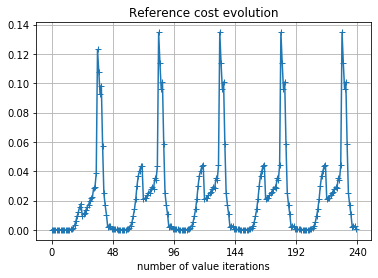

In [276]:
J, J_ref = dpsolv.eval_policy(pol_ini, 48*5, rel_dp=True, J_ref_full=True)
plt.plot(J_ref, '-+')
plt.title('Reference cost evolution');
plt.xlabel('number of value iterations');
plt.xticks(np.arange(6)*48)
plt.grid();

Observation: **convergence issue** of policy evaluation. The average cost per stage is periodic with period 48 (1 day). After two days, the periodic looks stabilized

Open questions:

* Is it related to the deterministic transition of the hour of the day $h$ ?
* Is there an impact of the cost to go function ?

For reference, this is the average cost per stage for the deterministic policy on the 30 days simulation with the test data:

In [227]:
0.563/48

0.011729166666666666

In [228]:
J_ref.mean()

0.0227156329929723

##### A look at the cost to go $\tilde{J}(x)$, with the effect of policy evaluation length

policy evaluation run in 11.44 s     


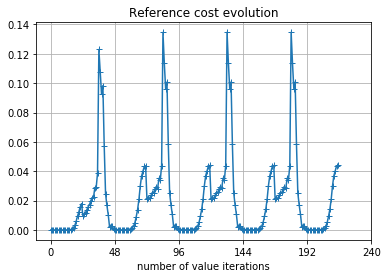

In [229]:
J_h12, J_ref = dpsolv.eval_policy(pol_ini, 48*4+24, rel_dp=True, J_ref_full=True)
plt.plot(J_ref, '-+')
plt.title('Reference cost evolution');
plt.xlabel('number of value iterations');
plt.xticks(np.arange(6)*48)
plt.grid();

policy evaluation run in 12.34 s     


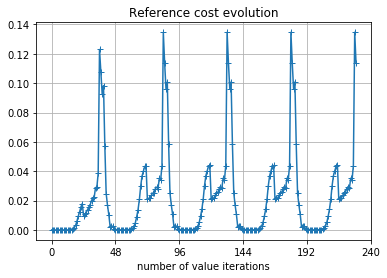

In [230]:
J_h19, J_ref = dpsolv.eval_policy(pol_ini, 48*4+38, rel_dp=True, J_ref_full=True)
plt.plot(J_ref, '-+')
plt.title('Reference cost evolution');
plt.xlabel('number of value iterations');
plt.xticks(np.arange(6)*48)
plt.grid();

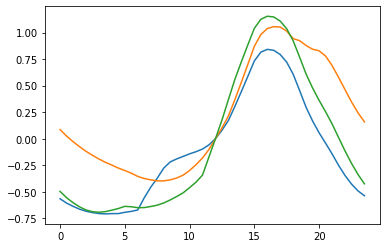

In [130]:
plt.plot(hod,J[n_E_sto//2,n_P_nl//2,:], label='h=0')
plt.plot(hod,J_h12[n_E_sto//2,n_P_nl//2,:], label='h=12')
plt.plot(hod,J_h19[n_E_sto//2,n_P_nl//2,:], label='h=19')

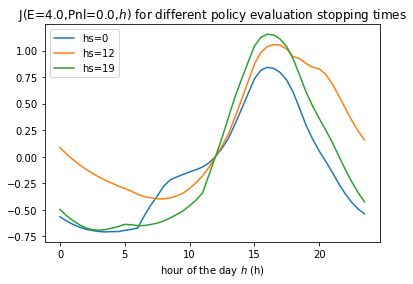

In [231]:
plt.plot(hod,J[n_E_sto//2,n_P_nl//2,:], label='hs=0')
plt.plot(hod,J_h12[n_E_sto//2,n_P_nl//2,:], label='hs=12')
plt.plot(hod,J_h19[n_E_sto//2,n_P_nl//2,:], label='hs=19')
plt.title('J(E={},Pnl={},$h$) for different policy evaluation stopping times'.format(
    dpsolv.state_grid[0][n_E_sto//2], dpsolv.state_grid[1][n_P_nl//2]
))
plt.xlabel('hour of the day $h$ (h)')
plt.legend();

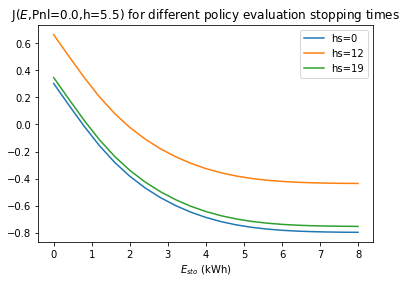

In [277]:
hi=11
plt.plot(E_sto_grid[:,0,0],J[:,n_P_nl//2,hi], label='hs=0')
plt.plot(E_sto_grid[:,0,0],J_h12[:,n_P_nl//2,hi], label='hs=12')
plt.plot(E_sto_grid[:,0,0],J_h19[:,n_P_nl//2,hi], label='hs=19')
plt.title('J($E$,Pnl={},h={}) for different policy evaluation stopping times'.format(
    dpsolv.state_grid[1][n_P_nl//2], hod[hi]
))
plt.xlabel('$E_{sto}$ (kWh)')
plt.legend();

In [233]:
im_opts = dict(interpolation='nearest', cmap = 'viridis',
                   extent=(-P_nl_max, P_nl_max, 0, E_rated),
                   #vmin=-P_rated, vmax=P_rated,
                   origin='lower', aspect='auto')
P_nl_label = 'Net load $P_{nl}$ (kW)'
E_sto_label = 'Storage energy $E_{sto}$ (kWh)'

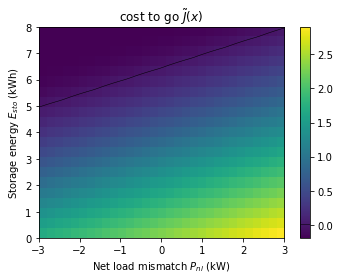

In [235]:
fig = plt.figure(figsize=(5,4))
hi=30
ax = fig.add_subplot(111, title=r'cost to go $\tilde{J}(x)$',
                          xlabel=P_nl_label, ylabel=E_sto_label)
im = ax.imshow(J[:,:,hi],  **im_opts)
cbar = fig.colorbar(im)#, ticks=mpl.ticker.MultipleLocator())
# contours
clines = ax.contour(P_nl_grid[:,:,hi], E_sto_grid[:,:,hi], J[:,:,hi],
                [1e-2],
                colors='k', linestyles='solid', linewidths=.5)
cbar.add_lines(clines)

fig.tight_layout()

#### **Step 3:** Run Policy Iteration algorithm

In [278]:
# Number of policy iterations:
n_pol = 4

# Number of value iterations
#(inner loop used for policy evaluation)
n_val = 96

# run
J, pol = dpsolv.policy_iteration(pol_ini, 
                                 n_val, n_pol,
                                 rel_dp=True)

policy evaluation run in 5.21 s     
ref policy cost: 0.000753202
policy iteration 1/4
value iteration run in 8.36 s
policy evaluation run in 5.27 s     
ref policy cost: 0.000266044
policy iteration 2/4
value iteration run in 8.39 s
policy evaluation run in 5.43 s     
ref policy cost: 0.000300682
policy iteration 3/4
value iteration run in 8.57 s
policy evaluation run in 5.46 s     
ref policy cost: 0.000330657
policy iteration 4/4
value iteration run in 8.38 s
policy evaluation run in 5.03 s     
ref policy cost: 0.000330607


## Plot SPD results

### Plot optimal policy

Extract the policy for each variable of interest:

* $P_{sto}(x)$
* $P_{gc}(x)$
* $E_{sto}(k+1)(x)$

In [279]:
pol_sto = pol[..., 0]
pol_gc = P_nl_grid + pol_sto
pol_E = E_sto_grid + pol_sto*dt
pol_sto.shape

(21, 31, 48)

Obs: optimized policy is different than init pol. 

* sometimes $P_{sto}$ is bigger (by 4.8 kW) → precharging?
* *if quadratic penalty, sometimes $P_{sto}$ is smaller (by 1.3 kW)

In [280]:
(pol - pol_ini).std()

0.39614636743629766

In [281]:
(pol - pol_ini).max(), (pol - pol_ini).min()

(4.800000000000001, -1.2999999999999998)

#### Policy as a function of hod

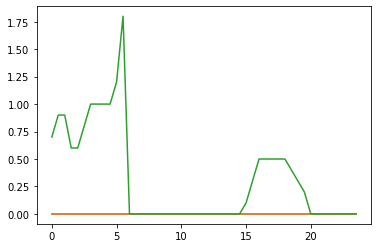

In [282]:
hod = np.arange(48)/2
plt.plot(hod,pol_gc[5,0,:])
plt.plot(hod,pol_gc[5,10,:])
plt.plot(hod,pol_gc[5,20,:]);

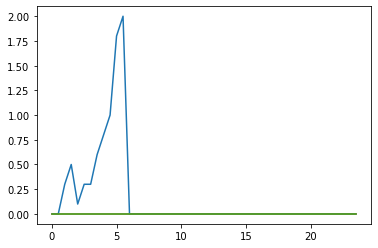

In [283]:
plt.plot(hod,pol_gc[0,10,:])
plt.plot(hod,pol_gc[5,10,:])
plt.plot(hod,pol_gc[8,10,:]);

In [284]:
im_opts = dict(interpolation='nearest', cmap = 'RdBu_r',
                   extent=(-P_nl_max, P_nl_max, 0, E_rated),
                   vmin=-P_rated, vmax=P_rated,
                   origin='lower', aspect='auto')
P_nl_label = 'Net load $P_{nl}$ (kW)'
E_sto_label = 'Storage energy $E_{sto}$ (kWh)'

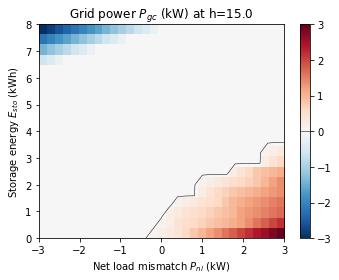

In [294]:
hi = 30

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, title='Grid power $P_{{gc}}$ (kW) at h={}'.format(hod[hi]),
                          xlabel=P_nl_label, ylabel=E_sto_label)
im = ax.imshow(pol_gc[:,:,hi],  **im_opts)
cbar = fig.colorbar(im)#, ticks=mpl.ticker.MultipleLocator())
# contours
clines = ax.contour(P_nl_grid[:,:,hi], E_sto_grid[:,:,hi], pol_gc[:,:,hi],
                [1e-2],
                colors='k', linestyles='solid', linewidths=.5)
cbar.add_lines(clines)

fig.tight_layout()

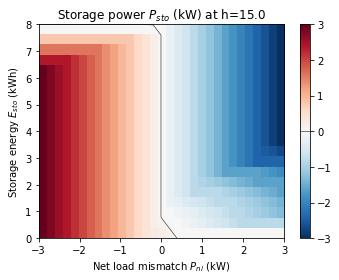

In [293]:
hi = 30

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, title='Storage power $P_{{sto}}$ (kW) at h={}'.format(hod[hi]),
                          xlabel=P_nl_label, ylabel=E_sto_label)
im = ax.imshow(pol_sto[:,:,hi],  **im_opts)
cbar = fig.colorbar(im)#, ticks=mpl.ticker.MultipleLocator())
# contours
clines = ax.contour(P_nl_grid[:,:,hi], E_sto_grid[:,:,hi], pol_sto[:,:,hi],
                [1e-2],
                colors='k', linestyles='solid', linewidths=.5)
cbar.add_lines(clines)

fig.tight_layout()

#### Policy for next stage $E_{sto}$

to get a more interpretable result than $P_{sto}$

Indeed, it seems that the policy create a flat zone of $E_{sto}(k+1)$ when batter is slightly depleted, to keep the SoE around a target (e.g. 2.5 kWh below)

In [309]:
im_opts = dict(interpolation='nearest', cmap = 'viridis',
                   extent=(-P_nl_max, P_nl_max, 0, E_rated),
                   vmin=0, vmax=E_rated,
                   origin='lower', aspect='auto')
P_nl_label = 'Net load $P_{nl}$ (kW)'
E_sto_label = 'Storage energy $E_{sto}$ (kWh)'

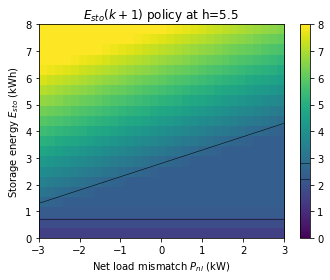

In [300]:
hi = 11

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, title='$E_{{sto}}(k+1)$ policy at h={}'.format(hod[hi]),
                          xlabel=P_nl_label, ylabel=E_sto_label)
im = ax.imshow(E_sto_grid[:,:,hi]+pol_sto[:,:,hi]*dt,  **im_opts)
cbar = fig.colorbar(im)#, ticks=mpl.ticker.MultipleLocator())
# contours
clines = ax.contour(P_nl_grid[:,:,hi], E_sto_grid[:,:,hi], E_sto_grid[:,:,hi]+pol_sto[:,:,hi]*dt,
                [2.2,2.8],
                colors='k', linestyles='solid', linewidths=.5)
cbar.add_lines(clines)

fig.tight_layout()

#### 3D plots of policy

In [328]:
from mpl_toolkits.mplot3d import Axes3D
surf_opts = dict(rstride=1, cstride=1,
                 vmin=-P_nl_max, vmax=P_nl_max,
                 cmap='RdBu_r', edgecolor=(0,0,0,0.2))
azim = 10

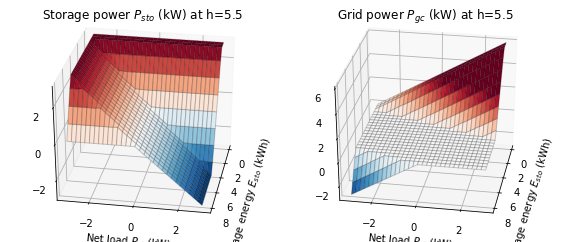

In [333]:
hi=11

fig = plt.figure(figsize=(8,3.5))
ax1 = fig.add_subplot(121, projection='3d',
                          title='Storage power $P_{{sto}}$ (kW) at h={}'.format(hod[hi]),
                          xlabel=E_sto_label, ylabel=P_nl_label,
                          )
ax1.plot_surface(E_sto_grid[:,:,0], P_nl_grid[:,:,0], pol_sto[:,:,hi], **surf_opts)
ax1.locator_params(nbins=5)
ax1.set_zlim(-P_nl_max, P_nl_max)
ax1.view_init(30, azim)

ax2 = fig.add_subplot(122, projection='3d',
                          title='Grid power $P_{{gc}}$ (kW) at h={}'.format(hod[hi]),
                          xlabel=E_sto_label, ylabel=P_nl_label
                      )
ax2.plot_surface(E_sto_grid[:,:,0], P_nl_grid[:,:,0], pol_gc[:,:,hi], **surf_opts)
ax2.locator_params(nbins=5)
ax1.set_zlim(-P_nl_max, P_nl_max)
ax2.view_init(30, azim)

fig.tight_layout()

--- 
## Simulation on test data


### Simulation

Interpolated control law:

In [330]:
control_P_sto = dpsolv.interp_on_state(pol_sto)

In [336]:
control_P_sto(2, 0, 5.5)

array(0.8)

Simulation loop

In [342]:
P_sto = np.zeros(n)
E_sto = np.zeros(n+1)
P_grid = np.zeros(n)
P_curt = np.zeros(n)

E_sto[0]= E_rated/2

for k in range(n):
    P_nl_k = P_load.values[k] - P_sun.values[k]
    h_k = (k%48)/2
    P_sto[k] = control_P_sto(E_sto[k], P_nl_k, h_k)
    P_gc_k = P_sto[k] + P_nl_k
    if P_gc_k>0:
        P_grid[k] = P_gc_k
        P_curt[k] = 0
    else:
        P_grid[k] = 0
        P_curt[k] = -P_gc_k
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    #assert 0 <= E_sto[k+1] <= E_rated

    
E_sto = E_sto[:-1]
P_pv = P_sun - P_curt
P_nl = P_load - P_sun

In [343]:
print('E_load: {:6.2f} kWh/d (data)'.format(P_load.mean()*24))
print('E_sun:  {:6.2f} kWh/d (data)'.format(P_sun.mean()*24))
print('E_pv:   {:6.2f} kWh/d'.format(P_pv.mean()*24))
print('E_curt: {:6.2f} kWh/d'.format(P_curt.mean()*24))
print('E_grid: {:6.2f} kWh/d'.format(P_grid.mean()*24))

E_load:  17.02 kWh/d (data)
E_sun:   15.60 kWh/d (data)
E_pv:    12.91 kWh/d
E_curt:   2.69 kWh/d
E_grid:   4.13 kWh/d


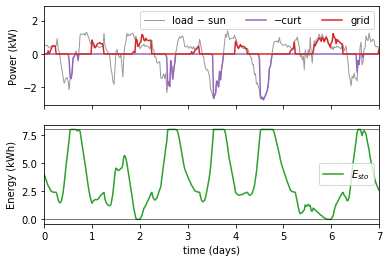

In [345]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(td, P_nl, label='load − sun',
           color=(0.6,)*3, lw=1)

ax[0].plot(td, -P_curt, label='−curt',
           color='tab:purple')

ax[0].plot(td, P_grid, label='grid',
           color='tab:red')

ax[0].legend(ncol=4)
ax[0].set(
    ylabel='Power (kW)'
)

ax[1].plot(td, E_sto, label='$E_{sto}$',
           color='tab:green');
ax[1].axhline(0, color='k', lw=0.5)
ax[1].axhline(E_rated, color='k', lw=0.5)

ax[1].legend()
ax[1].set(
    xlabel='time (days)',
    ylabel='Energy (kWh)',
    ylim=(-.05*E_rated, 1.05*E_rated),
    xlim=(0, 7)
);

### Write results

*in progress*...


In [ ]:
def save_results(name, params, data, stats, traj):
    import csv
    folder = Path('results')
    meta_fname = folder / f'{name}_meta.csv'
    stat_fname = folder / f'{name}_stat.csv'
    traj_fname = folder / f'{name}_traj.csv'

    with open(meta_fname, 'w') as f:
        f.write('control method,E_rated,P_pvp\n')
        f.write('{},{:.3f},{:.3f}\n'.format(name, params['E_rated'], params['P_pvp']))
    
    with open(stat_fname, 'w', newline='\n') as f:
        fcsv = csv.writer(f, delimiter=',')
        stat_order = [
            'P_sto',
            'P_load_sp','P_shed','P_load', # load
            'P_sun','P_curt','P_pv', # sun
            'P_grid','C_grid']
        fcsv.writerow(stat_order)
    
        stat_mat = np.array([stats[k] for k in stat_order])
        # round almost zero values
        np.where(np.abs(stat_mat) <= 1e-13, 0, stat_mat)
        fcsv.writerow(stat_mat)
    
    # TO BE CONTINUED
    with open(meta_fname, 'w') as f:
    traj_header = ',E_sto,P_sto,P_load_sp,P_shed,P_load,P_sun,P_curt,P_pv,P_grid,c_grid'
    println(f, traj_header)
    
    traj_mat = hcat(data['t'],
      traj['E_sto'], traj['P_sto'], # storage
      traj['P_load_sp'], traj['P_shed'], traj['P_load'], # load
      traj['P_sun'], traj['P_curt'], traj['P_pv'], # sun
      traj['P_grid'], traj['c_grid'])
    writecsv(f, traj_mat)
    close(f)
    
    print('result files for method \'{}\' written!'.format(name))